In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def identify_low_variance_parameters(data, variance_threshold=0.002):
    low_variance_parameters = []
    numeric_cols = data.select_dtypes(include=[np.number])  # Select only numeric columns
    x_columns = [col for col in data.columns if col.startswith('X')]
    for column in x_columns:
        # Calculate mean
        mean = numeric_cols[column].mean()

        # Calculate variance manually to save memory
        sum_squared_diff = ((numeric_cols[column] - mean) ** 2).sum()
        variance = sum_squared_diff / (len(numeric_cols[column]) - 1)

        if variance < variance_threshold:
            low_variance_parameters.append(column)
            print('variance', column, variance)

    return low_variance_parameters

def identify_high_uniqueness_parameters(data, uniqueness_threshold=0.01):
    high_uniqueness_parameters = []
    x_columns = [col for col in data.columns if col.startswith('X')]

    for column in x_columns:
        unique_ratio = len(data[column].unique()) / len(data)
        if unique_ratio < uniqueness_threshold:
            print(f"Column: {column}, Unique Ratio: {unique_ratio:.5f}")
            high_uniqueness_parameters.append(column)

    return high_uniqueness_parameters

def classify_parameters(data, y_variables):
    low_variance = identify_low_variance_parameters(data)
    high_uniqueness = identify_high_uniqueness_parameters(data)

    # Exclude the target variables from the lists
    low_variance = [param for param in low_variance if param not in y_variables]
    high_uniqueness = [param for param in high_uniqueness if param not in y_variables]
    return low_variance, high_uniqueness


# Read the data
in_sample_data = pd.read_pickle('Datasave/in_sample_data.pkl.bz2', compression='bz2')

# Classify parameters for in-sample data
y_variables = ['Y1', 'Y2']  # List of target variables
in_low_variance, in_high_uniqueness = classify_parameters(in_sample_data, y_variables)
filter1 = in_sample_data.drop(columns=in_low_variance + in_high_uniqueness)

# Print out the lists for verification
print("In-sample Low Variance Parameters:", in_low_variance)
print("In-sample High Uniqueness Parameters:", in_high_uniqueness)



variance X164 0.0007430914270030259
variance X166 0.0003325992472555751
variance X167 0.0005951949158609978
variance X168 9.352426781525564e-05
variance X169 0.0002473950727437666
variance X262 0.0015423875867126438
variance X263 0.001603491369712849
Column: X147, Unique Ratio: 0.00311
Column: X149, Unique Ratio: 0.00366
Column: X151, Unique Ratio: 0.00311
Column: X153, Unique Ratio: 0.00366
Column: X155, Unique Ratio: 0.00311
Column: X157, Unique Ratio: 0.00366
Column: X45, Unique Ratio: 0.00020
Column: X46, Unique Ratio: 0.00493
In-sample Low Variance Parameters: ['X164', 'X166', 'X167', 'X168', 'X169', 'X262', 'X263']
In-sample High Uniqueness Parameters: ['X147', 'X149', 'X151', 'X153', 'X155', 'X157', 'X45', 'X46']


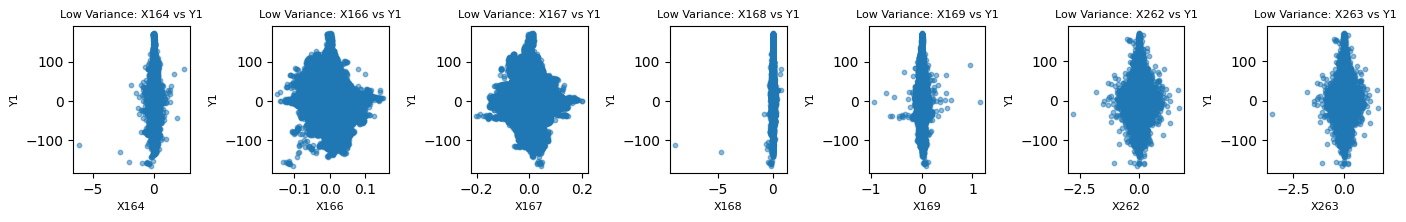

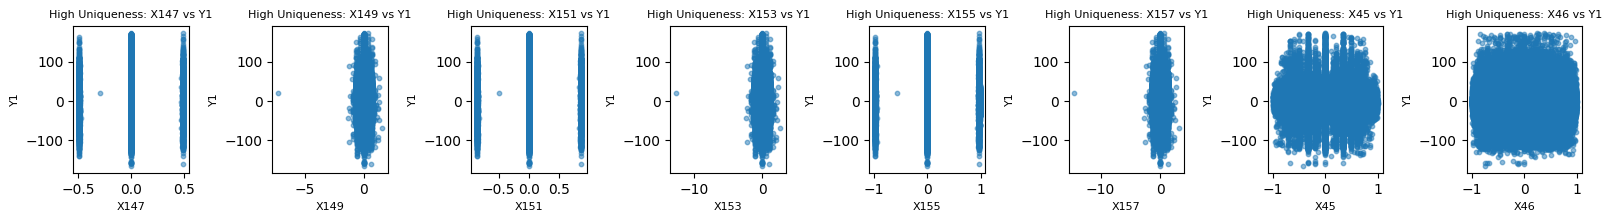

In [3]:
import matplotlib.pyplot as plt

def plot_parameters(data, parameters, y_variable, grid_size=10, title_prefix=""):
    num_parameters = len(parameters)
    plots_needed = int(np.ceil(num_parameters / (grid_size**2)))

    for plot_index in range(plots_needed):
        plt.figure(figsize=(20, 20))
        for i in range(grid_size**2):
            param_index = plot_index * (grid_size**2) + i
            if param_index < num_parameters:
                plt.subplot(grid_size, grid_size, i+1)
                plt.scatter(data[parameters[param_index]], data[y_variable], alpha=0.5, s=10)
                plt.title(f'{title_prefix}{parameters[param_index]} vs {y_variable}', fontsize=8)
                plt.xlabel(parameters[param_index], fontsize=8)
                plt.ylabel(y_variable, fontsize=8)
            else:
                break
        plt.tight_layout()
        plt.show()

# # Example usage for each category
plot_parameters(in_sample_data, in_low_variance, 'Y1', title_prefix="Low Variance: ")
plot_parameters(in_sample_data, in_high_uniqueness, 'Y1', title_prefix="High Uniqueness: ")


In [4]:
# Function to remove outliers
def replace_outliers_with_na(data, columns):
    """
    Replaces outliers in the specified columns of the DataFrame with NA based on the IQR method.
    Args:
    data (DataFrame): The DataFrame to process.
    columns (list): List of column names to check for outliers.
    Returns:
    DataFrame: Data with outliers replaced by NA.
    """
    for column in columns:
        if data[column].dtype in ['float64', 'float32', 'int64', 'int32']:
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            outlier_filter = ~((data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR))
            data.loc[outlier_filter, column] = pd.NA
    return data
# in_sample_data = replace_outliers_with_na(in_sample_data, x_columns)

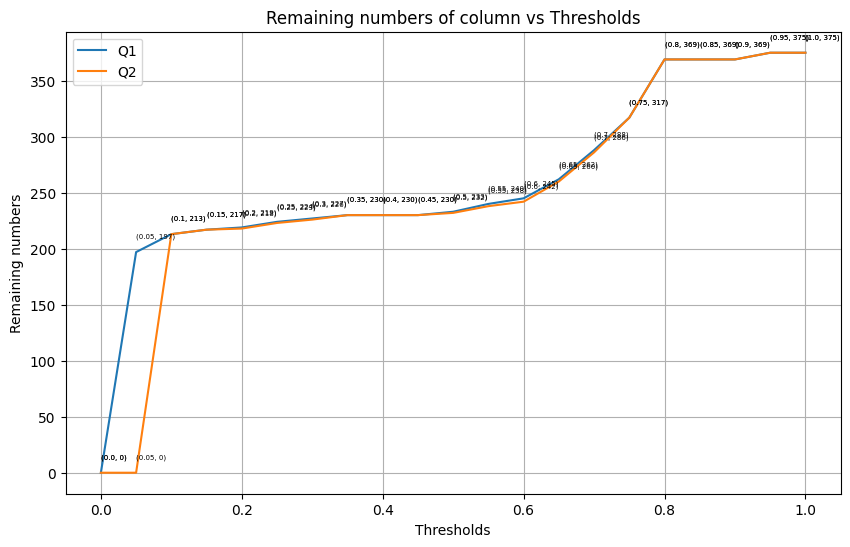

In [5]:
# Function to calculate the ratio of bad values in a column
def calculate_bad_value_ratio(data, column, q_column):
    """
    Calculates the ratio of bad values in a specific column based on a quality metric column.
    Args:
    data (DataFrame): The DataFrame containing the data.
    column (str): The name of the column to calculate the ratio for.
    q_column (str): The name of the quality metric column.
    Returns:
    float: The ratio of bad values in the column.
    """
    # Mark values as NA in the column if the corresponding value in the quality column is below a threshold
    data.loc[data[q_column] < 0.9999, column] = pd.NA

    # Count the number of NA, null, or zero values
    bad_values_count = data[column].isna().sum() + (data[column] == 0).sum()

    # Calculate and return the ratio of bad values in the column
    return bad_values_count / len(data[column])

# Function to get cumulative counts of bad values
def get_counts(data, x_columns, q_columns, thresholds):
    """
    Calculates cumulative counts of columns exceeding various thresholds for bad values.
    Args:
    data (DataFrame): The DataFrame containing the data.
    x_columns (list): List of columns to check.
    q_columns (list): List of quality columns.
    thresholds (list): List of thresholds to check against.
    Returns:
    dict: A dictionary with cumulative counts.
    """
    counts = {}
    for q_col in q_columns:
        # Calculate bad value ratio for each column
        ratios = [calculate_bad_value_ratio(data, x, q_col) for x in x_columns]
        # Count the number of columns exceeding each threshold
        counts[q_col] = {threshold: np.sum(np.array(ratios) < threshold) for threshold in thresholds}
    return counts

# Function to plot cumulative counts
def plot_counts(cumulative_counts, q_columns, thresholds, save_path):
    """
    Plots the cumulative counts of columns exceeding various thresholds for bad values.
    Args:
    cumulative_counts (dict): Dictionary with cumulative counts.
    q_columns (list): List of quality columns.
    thresholds (list): List of thresholds used.
    save_path (str): Path to save the plot.
    """
    plt.figure(figsize=(10, 6))
    # Plot counts for each quality column with annotations
    for q_col in q_columns:
        counts = [cumulative_counts[q_col][th] for th in thresholds]
        plt.plot(thresholds, counts, label=f'{q_col}')

        # # Annotate each point on the plot with its (x, y) coordinates
        # for i, count in enumerate(counts):
        #     annotation_text = f'({thresholds[i]}, {count})'
        #     plt.annotate(annotation_text, (thresholds[i], counts[i]), textcoords="offset points", xytext=(0,10), ha='left', fontsize=5)

    # Set plot labels and title
    plt.xlabel('Thresholds')
    plt.ylabel('Remaining numbers')
    plt.title('Remaining numbers of column vs Thresholds')
    plt.grid(True)
    plt.legend()


# Load in-sample data
# in_sample_data = pd.read_pickle('Datasave/in_sample_data.pkl.bz2', compression='bz2')
# Identify columns starting with 'X'
x_columns = [col for col in in_sample_data.columns if col.startswith('X')]
# Define quality columns and thresholds
q_columns = ['Q1', 'Q2']
thresholds = np.round(np.arange(0, 1.05, 0.05), 2)

# Calculate cumulative counts for bad values
cumulative_counts = get_counts(in_sample_data, x_columns, q_columns, thresholds)

# Plot and save the cumulative counts
plot_save_path = 'Plot n result save/missing_value_cumulative_counts_plot.png'
plot_counts(cumulative_counts, q_columns, thresholds, plot_save_path)


In [6]:
display(cumulative_counts)

{'Q1': {0.0: 0,
  0.05: 197,
  0.1: 213,
  0.15: 217,
  0.2: 219,
  0.25: 224,
  0.3: 227,
  0.35: 230,
  0.4: 230,
  0.45: 230,
  0.5: 233,
  0.55: 240,
  0.6: 245,
  0.65: 262,
  0.7: 288,
  0.75: 317,
  0.8: 369,
  0.85: 369,
  0.9: 369,
  0.95: 375,
  1.0: 375},
 'Q2': {0.0: 0,
  0.05: 0,
  0.1: 213,
  0.15: 217,
  0.2: 218,
  0.25: 223,
  0.3: 226,
  0.35: 230,
  0.4: 230,
  0.45: 230,
  0.5: 232,
  0.55: 238,
  0.6: 242,
  0.65: 260,
  0.7: 286,
  0.75: 317,
  0.8: 369,
  0.85: 369,
  0.9: 369,
  0.95: 375,
  1.0: 375}}

In [7]:
def filter_bad_values_and_save(data, q_column, threshold, x_columns, temp_file_path):
    """
    Filters bad values from the data based on a threshold and saves the filtered data.
    Args:
    data (DataFrame): The DataFrame to process.
    q_column (str): The quality column to base the filtering on.
    threshold (float): The threshold for bad value ratio.
    x_columns (list): List of columns to filter.
    temp_file_path (str): Path to save the filtered data.
    Returns:
    DataFrame: The filtered DataFrame.
    """    
    additional_columns = []
    filtered_data = data.iloc[:,0:3].copy()
    filtered_data['date'] = data['date']
    if q_column == "Q1":
        filtered_data[["Y1", "Q1"]] = data[["Y1", "Q1"]]
    else:
        filtered_data[["Y2", "Q2"]] = data[["Y2", "Q2"]]

    additional_columns = []

    for column in x_columns:
        bad_values_ratio = calculate_bad_value_ratio(data, column, q_column)
        if bad_values_ratio < threshold:
            additional_columns.append(data[column])
    # Concatenate additional columns all at once
    filtered_data = pd.concat(  [filtered_data] + additional_columns, axis=1)

    # Sorting by 'date' and 'time'
    filtered_data.sort_values(by=['date', 'time'], inplace=True)
    filtered_data.to_pickle(temp_file_path)
    display(filtered_data)
    
    return filtered_data

# Filtering bad values and saving
for q_col in ['Q1', 'Q2']:
    print(f"Number's of parameter for {q_col} before cleaning: {len(x_columns)}")
    for i in [0.6]:
        filter2 = filter_bad_values_and_save(filter1, q_col, i, x_columns, f'Datasave/{q_col}_filtered_{i}.pkl')
        x_columns_after = [col for col in filter2.columns if col.startswith('X')]
        print(f"Number's of parameter for {q_col} after cleaning (threshold = {i}): {len(x_columns_after)}")
    print("")

Number's of parameter for Q1 before cleaning: 375


,time,sym,exch,date,Y1,Q1,X1,X10,X100,X101,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
0,35101000,SPX,cme,2022-01-03,-4.967191e+01,1.00,-1.985130,-0.440099,0.044736,-0.010772,...,0.036888,0.020226,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752
1,35102000,SPX,cme,2022-01-03,-4.889528e+01,1.00,-0.933646,-0.380986,-0.854499,-0.951011,...,-0.852265,-0.910145,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521
2,35103000,SPX,cme,2022-01-03,-4.706744e+01,1.00,-0.579249,-0.180915,-0.854372,-0.969687,...,-0.842401,-0.919075,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525
3,35104000,SPX,cme,2022-01-03,-4.759041e+01,1.00,-0.658292,-0.028344,-0.044026,-0.496256,...,-0.031957,-0.441668,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654
4,35105000,SPX,cme,2022-01-03,-4.811086e+01,1.00,-1.331419,-0.100419,0.273158,0.218558,...,0.281678,0.268776,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254995,57596000,SPX,cme,2023-02-28,-8.803647e+00,0.21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254996,57597000,SPX,cme,2023-02-28,-8.175329e+00,0.21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254997,57598000,SPX,cme,2023-02-28,-5.661267e+00,1.00,-1.213168,-1.136721,NaN,-0.878878,...,NaN,-0.866625,-1.709110,-1.746943,-1.751714,NaN,-0.377860,-1.943471,-1.894090,-1.764978
6254998,57599000,SPX,cme,2023-02-28,-3.774891e+00,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number's of parameter for Q1 after cleaning (threshold = 0.6): 238

Number's of parameter for Q2 before cleaning: 375


,time,sym,exch,date,Y2,Q2,X1,X10,X100,X101,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
0,35101000,SPX,cme,2022-01-03,-61.707756,1.00,-1.985130,-0.440099,0.044736,-0.010772,...,0.036888,0.020226,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752
1,35102000,SPX,cme,2022-01-03,-62.025402,1.00,-0.933646,-0.380986,-0.854499,-0.951011,...,-0.852265,-0.910145,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521
2,35103000,SPX,cme,2022-01-03,-57.324017,1.00,-0.579249,-0.180915,-0.854372,-0.969687,...,-0.842401,-0.919075,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525
3,35104000,SPX,cme,2022-01-03,-58.769417,1.00,-0.658292,-0.028344,-0.044026,-0.496256,...,-0.031957,-0.441668,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654
4,35105000,SPX,cme,2022-01-03,-59.984489,1.00,-1.331419,-0.100419,0.273158,0.218558,...,0.281678,0.268776,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254995,57596000,SPX,cme,2023-02-28,-5.074302,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254996,57597000,SPX,cme,2023-02-28,-4.039149,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254997,57598000,SPX,cme,2023-02-28,-1.761056,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254998,57599000,SPX,cme,2023-02-28,-1.346745,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number's of parameter for Q2 after cleaning (threshold = 0.6): 235



In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

def convert_to_timeseries_and_save(file_path, output_file_path):
    # Load the data
    df = pd.read_pickle(file_path)

    # Convert 'time' from milliseconds to a standard time format
    df['time'] = pd.to_datetime(df['time'], unit='ms', origin='unix').dt.time

    # Combine 'date' and 'time' columns to create a 'datetime' column
    datetime_col = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    # Concatenate the new 'datetime' column to the DataFrame
    df = pd.concat([df, datetime_col.rename('datetime')], axis=1)

    # Set the new 'datetime' column as the index
    df.set_index('datetime', inplace=True)

    # Save the transformed DataFrame
    df.to_pickle(output_file_path)


# Apply the function to your files and save the transformed DataFrames
convert_to_timeseries_and_save('Datasave/Q1_filtered_0.6.pkl', 'Datasave/Q1_filtered2_0.6.pkl')
convert_to_timeseries_and_save('Datasave/Q2_filtered_0.6.pkl', 'Datasave/Q2_filtered2_0.6.pkl')


In [1]:
import pandas as pd

def resample_and_save(file_path, save_path, frequency):
    # Read the data from the pklpkl file
    df = pd.read_pickle(file_path)

    # Check if 'time' is the index and in datetime format; if not, set it accordingly
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index of DataFrame is not in datetime format. Please set the 'time' column as a datetime index.")

    # Drop rows where Q1 or Q2 is not equal to 1, depending on the dataset
    if 'Q1' in df.columns:
        df = df[df['Q1'] == 1]
    elif 'Q2' in df.columns:
        df = df[df['Q2'] == 1]

    # Select only numeric columns for resampling
    numeric_cols = df.select_dtypes(include=['number']).columns
    numeric_df = df[numeric_cols]

    # Resample the numeric data into specified intervals
    resampled_df = numeric_df.resample(frequency).mean()

    # Save the resampled data into a new pkl file
    resampled_df.to_pickle(save_path)

    display(resampled_df)

# Call the function for each dataset with specific file paths
resample_and_save('Datasave/Q1_filtered2_0.6.pkl', 'Datasave/Q1_resample_20min_0.6.pkl', '20T')
resample_and_save('Datasave/Q2_filtered2_0.6.pkl', 'Datasave/Q2_resample_20min_0.6.pkl', '20T')
resample_and_save('Datasave/Q1_filtered2_0.6.pkl', 'Datasave/Q1_resample_1H_0.6.pkl', '1H')
resample_and_save('Datasave/Q2_filtered2_0.6.pkl', 'Datasave/Q2_resample_1H_0.6.pkl', '1H')
resample_and_save('Datasave/Q1_filtered2_0.6.pkl', 'Datasave/Q1_resample_5min_0.6.pkl', '5T')
resample_and_save('Datasave/Q2_filtered2_0.6.pkl', 'Datasave/Q2_resample_5min_0.6.pkl', '5T')



,Y2,Q2,X1,X10,X100,X101,X102,X103,X104,X105,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:00,-68.916405,1.0,-1.283752,0.199685,-0.445947,-0.380401,0.037655,-0.006059,-0.281455,-1.153800,...,-0.346282,-0.274244,0.012385,-0.024411,-2.095855,-1.403409,0.220978,-1.602571,-0.436012,-0.195625
2022-01-03 09:46:00,-57.244083,1.0,-1.456279,0.093618,-0.011166,-0.048088,-0.069050,-0.067432,-0.400778,-0.939911,...,0.057991,0.020293,-0.054957,-0.046346,-2.226876,-1.313988,0.207034,-1.735023,-0.595729,-0.064621
2022-01-03 09:47:00,-44.230671,1.0,-1.220253,0.346819,-0.686945,-0.654555,-0.201947,-0.266889,-0.965056,-1.722073,...,-0.588577,-0.557882,-0.178506,-0.227016,-2.813459,-2.213199,-0.670578,-1.887072,-0.901227,-0.449451
2022-01-03 09:48:00,-30.124870,1.0,-0.523347,0.875238,-0.498254,-0.390335,0.239504,0.218167,-0.895898,-2.365163,...,-0.256482,-0.171926,0.275094,0.262772,-2.839967,-3.109001,-1.435148,-1.663556,-0.694604,0.030180
2022-01-03 09:49:00,-19.056105,1.0,-0.681893,1.034022,0.132288,0.140381,0.185169,0.214836,-0.501507,-1.599728,...,0.157760,0.152686,0.093659,0.123580,-2.468600,-2.552301,-0.936961,-1.210065,-0.218373,0.109833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:51:00,6.127572,1.0,0.069736,0.427943,0.146892,0.083394,0.001710,0.125797,0.178687,0.466546,...,0.100864,0.052349,-0.038753,0.045601,0.202868,0.494266,0.324019,0.277543,0.676470,0.024801
2023-02-28 15:52:00,-5.406089,1.0,0.062463,0.460726,-0.058669,-0.005143,-0.039611,0.037427,0.106041,0.226448,...,-0.055065,-0.007857,-0.022112,0.019866,0.141450,0.289012,0.265830,0.170754,0.658042,0.013514
2023-02-28 15:53:00,-9.364498,1.0,0.451846,0.615601,-0.108331,-0.116679,0.204161,0.118892,0.318200,0.085200,...,-0.088643,-0.103595,0.166046,0.079768,0.367326,0.158437,0.102800,0.507887,0.822102,0.161486


,Y1,Q1,X1,X10,X100,X101,X102,X103,X104,X105,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:00,-57.209728,1.0,-1.283752,0.199685,-0.445947,-0.380401,0.037655,-0.006059,-0.281455,-1.153800,...,-0.346282,-0.274244,0.012385,-0.024411,-2.095855,-1.403409,0.220978,-1.602571,-0.436012,-0.195625
2022-01-03 09:46:00,-40.317455,1.0,-1.456279,0.093618,-0.011166,-0.048088,-0.069050,-0.067432,-0.400778,-0.939911,...,0.057991,0.020293,-0.054957,-0.046346,-2.226876,-1.313988,0.207034,-1.735023,-0.595729,-0.064621
2022-01-03 09:47:00,-20.889744,1.0,-1.220253,0.346819,-0.686945,-0.654555,-0.201947,-0.266889,-0.965056,-1.722073,...,-0.588577,-0.557882,-0.178506,-0.227016,-2.813459,-2.213199,-0.670578,-1.887072,-0.901227,-0.449451
2022-01-03 09:48:00,-4.729346,1.0,-0.523347,0.875238,-0.498254,-0.390335,0.239504,0.218167,-0.895898,-2.365163,...,-0.256482,-0.171926,0.275094,0.262772,-2.839967,-3.109001,-1.435148,-1.663556,-0.694604,0.030180
2022-01-03 09:49:00,3.999715,1.0,-0.681893,1.034022,0.132288,0.140381,0.185169,0.214836,-0.501507,-1.599728,...,0.157760,0.152686,0.093659,0.123580,-2.468600,-2.552301,-0.936961,-1.210065,-0.218373,0.109833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:55:00,-25.398653,1.0,-0.245934,0.386981,0.751813,0.248333,0.090503,0.124971,0.162453,0.877417,...,0.705886,0.160382,0.091211,0.099480,0.265302,0.948899,0.700535,0.178235,0.784026,0.021591
2023-02-28 15:56:00,-25.080790,1.0,0.109287,0.507738,NaN,-0.034604,-0.153759,0.098470,0.264164,NaN,...,NaN,-0.045472,-0.118442,0.072896,0.383405,NaN,0.457278,-0.185084,0.843262,0.109684
2023-02-28 15:57:00,-24.558887,1.0,0.197109,0.564695,NaN,-0.075937,0.058000,0.019497,0.215763,NaN,...,NaN,-0.062453,0.047957,-0.001618,0.361845,NaN,0.347263,0.038885,0.842083,0.005634


,Y1,Q1,X1,X10,X100,X101,X102,X103,X104,X105,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:00,-57.209728,1.0,-1.283752,0.199685,-0.445947,-0.380401,0.037655,-0.006059,-0.281455,-1.153800,...,-0.346282,-0.274244,0.012385,-0.024411,-2.095855,-1.403409,0.220978,-1.602571,-0.436012,-0.195625
2022-01-03 09:46:00,-40.317455,1.0,-1.456279,0.093618,-0.011166,-0.048088,-0.069050,-0.067432,-0.400778,-0.939911,...,0.057991,0.020293,-0.054957,-0.046346,-2.226876,-1.313988,0.207034,-1.735023,-0.595729,-0.064621
2022-01-03 09:47:00,-20.889744,1.0,-1.220253,0.346819,-0.686945,-0.654555,-0.201947,-0.266889,-0.965056,-1.722073,...,-0.588577,-0.557882,-0.178506,-0.227016,-2.813459,-2.213199,-0.670578,-1.887072,-0.901227,-0.449451
2022-01-03 09:48:00,-4.729346,1.0,-0.523347,0.875238,-0.498254,-0.390335,0.239504,0.218167,-0.895898,-2.365163,...,-0.256482,-0.171926,0.275094,0.262772,-2.839967,-3.109001,-1.435148,-1.663556,-0.694604,0.030180
2022-01-03 09:49:00,3.999715,1.0,-0.681893,1.034022,0.132288,0.140381,0.185169,0.214836,-0.501507,-1.599728,...,0.157760,0.152686,0.093659,0.123580,-2.468600,-2.552301,-0.936961,-1.210065,-0.218373,0.109833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:55:00,-25.398653,1.0,-0.245934,0.386981,0.751813,0.248333,0.090503,0.124971,0.162453,0.877417,...,0.705886,0.160382,0.091211,0.099480,0.265302,0.948899,0.700535,0.178235,0.784026,0.021591
2023-02-28 15:56:00,-25.080790,1.0,0.109287,0.507738,NaN,-0.034604,-0.153759,0.098470,0.264164,NaN,...,NaN,-0.045472,-0.118442,0.072896,0.383405,NaN,0.457278,-0.185084,0.843262,0.109684
2023-02-28 15:57:00,-24.558887,1.0,0.197109,0.564695,NaN,-0.075937,0.058000,0.019497,0.215763,NaN,...,NaN,-0.062453,0.047957,-0.001618,0.361845,NaN,0.347263,0.038885,0.842083,0.005634


,Y1,Q1,X1,X10,X100,X101,X102,X103,X104,X105,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:00,-57.209728,1.0,-1.283752,0.199685,-0.445947,-0.380401,0.037655,-0.006059,-0.281455,-1.153800,...,-0.346282,-0.274244,0.012385,-0.024411,-2.095855,-1.403409,0.220978,-1.602571,-0.436012,-0.195625
2022-01-03 09:46:00,-40.317455,1.0,-1.456279,0.093618,-0.011166,-0.048088,-0.069050,-0.067432,-0.400778,-0.939911,...,0.057991,0.020293,-0.054957,-0.046346,-2.226876,-1.313988,0.207034,-1.735023,-0.595729,-0.064621
2022-01-03 09:47:00,-20.889744,1.0,-1.220253,0.346819,-0.686945,-0.654555,-0.201947,-0.266889,-0.965056,-1.722073,...,-0.588577,-0.557882,-0.178506,-0.227016,-2.813459,-2.213199,-0.670578,-1.887072,-0.901227,-0.449451
2022-01-03 09:48:00,-4.729346,1.0,-0.523347,0.875238,-0.498254,-0.390335,0.239504,0.218167,-0.895898,-2.365163,...,-0.256482,-0.171926,0.275094,0.262772,-2.839967,-3.109001,-1.435148,-1.663556,-0.694604,0.030180
2022-01-03 09:49:00,3.999715,1.0,-0.681893,1.034022,0.132288,0.140381,0.185169,0.214836,-0.501507,-1.599728,...,0.157760,0.152686,0.093659,0.123580,-2.468600,-2.552301,-0.936961,-1.210065,-0.218373,0.109833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:55:00,-25.398653,1.0,-0.245934,0.386981,0.751813,0.248333,0.090503,0.124971,0.162453,0.877417,...,0.705886,0.160382,0.091211,0.099480,0.265302,0.948899,0.700535,0.178235,0.784026,0.021591
2023-02-28 15:56:00,-25.080790,1.0,0.109287,0.507738,NaN,-0.034604,-0.153759,0.098470,0.264164,NaN,...,NaN,-0.045472,-0.118442,0.072896,0.383405,NaN,0.457278,-0.185084,0.843262,0.109684
2023-02-28 15:57:00,-24.558887,1.0,0.197109,0.564695,NaN,-0.075937,0.058000,0.019497,0.215763,NaN,...,NaN,-0.062453,0.047957,-0.001618,0.361845,NaN,0.347263,0.038885,0.842083,0.005634


SystemError: deallocated bytearray object has exported buffers

MemoryError: 